In [1035]:
import sys
import random
import math
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
import matplotlib.pyplot as plt

In [1057]:
def read_mnist(file_name):
    
    data_set = []
    with open(file_name,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(',')
            label = tokens[0]
            attribs = []
            for i in range(784):
                attribs.append(tokens[i+1])
            data_set.append([label,attribs])
    return(data_set)
        
def show_mnist(file_name,mode):
    
    data_set = read_mnist(file_name)
    for obs in range(len(data_set)):
        for idx in range(784):
            if mode == 'pixels':
                if data_set[obs][1][idx] == '0':
                    print(' ',end='')
                else:
                    print('*',end='')
            else:
                print('%4s ' % data_set[obs][1][idx],end='')
            if (idx % 28) == 27:
                print(' ')
        print('LABEL: %s' % data_set[obs][0],end='')
        print(' ')
                   
def read_insurability(file_name):
    
    count = 0
    data = []
    with open(file_name,'rt') as f:
        for line in f:
            if count > 0:
                line = line.replace('\n','')
                tokens = line.split(',')
                if len(line) > 10:
                    x1 = float(tokens[0])
                    x2 = float(tokens[1])
                    x3 = float(tokens[2])
                    if tokens[3] == 'Good':
                        cls = 0
                    elif tokens[3] == 'Neutral':
                        cls = 1
                    else:
                        cls = 2
                    data.append([[cls],[x1,x2,x3]])
            count = count + 1
    return(data)
               
class FeedForward(nn.Module):
    def __init__(self) -> None:
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(3, 32)
        self.relu1 = nn.LeakyReLU()
        self.linear_out = nn.Linear(32, 3)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear_out(x)
        return x
    
class FFMNSIT(nn.Module):
    def __init__(self) -> None:
        super(FFMNSIT, self).__init__()
        self.linear1 = nn.Linear(784, 16)
        self.relu1 = nn.LeakyReLU()
        self.linear2 = nn.Linear(16, 32)
        self.relu2 = nn.LeakyReLU()
        self.linear_out = nn.Linear(32, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear_out(x)
        return x

def softmax(x: torch.Tensor) -> torch.Tensor:
    e_x = torch.exp(x - torch.max(x))
    return e_x / e_x.sum()

def classify_insurability() -> None:
    """ Data format:
    [
        [[Label], [x1, x2, x3]],
        ...
    ]
    """
    # Data loading -------------------------------------------------------------
    train = read_insurability('three_train.csv')
    valid = read_insurability('three_valid.csv')
    test = read_insurability('three_test.csv')

    train_data = [example[1] for example in train]
    train_labels = [example[0][0] for example in train]

    valid_data = [example[1] for example in valid]
    valid_labels = [example[0][0] for example in valid]

    test_data = [example[1] for example in test]
    test_labels = [example[0][0] for example in test]

    train_dataset = TensorDataset(torch.tensor(train_data), torch.tensor(train_labels))
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

    valid_dataset = TensorDataset(torch.tensor(valid_data), torch.tensor(valid_labels))
    valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)

    test_dataset = TensorDataset(torch.tensor(test_data), torch.tensor(test_labels))
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

    # End data loading ---------------------------------------------------------

    # Initialize model
    ff = FeedForward()
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(ff.parameters(), lr=0.01)

    # Train and validate
    train_losses = []
    valid_losses = []
    ff.train()
    EPOCHS = 50
    for _ in range(EPOCHS):
        epoch_train_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            y_pred = ff(x)
            loss_val = loss(y_pred, y)
            epoch_train_loss += loss_val.item()
            loss_val.backward()
            optimizer.step()
        train_losses.append(epoch_train_loss)
        
        epoch_loss_test = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = ff(inputs)
                loss_val = loss(outputs, labels)
                epoch_loss_test += loss_val.item()
        valid_losses.append(epoch_loss_test)

    # Plot losses
    plt.plot([i for i in range(len(train_losses))], train_losses)
    plt.title("Training Loss vs. Epoch")
    plt.figure()
    plt.plot([i for i in range(len(valid_losses))], valid_losses)
    plt.title("Validation Loss vs. Epoch")

    # Evaluate
    ff.eval()
    with torch.no_grad():
        test_examples = torch.tensor(test_data)
        outputs = ff(test_examples)
        probs_list = [softmax(output) for output in outputs]
        predicted_labels = [torch.argmax(probs) for probs in probs_list]
    correct = [predicted_labels[i] == test_labels[i] for i in range(len(predicted_labels))]
    print(f'Accuracy: {100 * sum(correct) / len(correct)}%')
    matrix = metrics.confusion_matrix(test_labels, predicted_labels)
    matrix_display = metrics.ConfusionMatrixDisplay(matrix)
    matrix_display.plot()
    plt.show()

def classify_mnist() -> None:
    """Data Format:
    [
        [Label, [Pixel_1,..., Pixel_784]],
    ]
    """
    train = read_mnist('mnist_train.csv')
    valid = read_mnist('mnist_valid.csv')
    test = read_mnist('mnist_test.csv')
    # show_mnist('mnist_test.csv','pixels')

    # Data loading -------------------------------------------------------------
    train_data = [list(map(lambda x: float(x)/255, example[1])) for example in train]
    train_labels = [int(example[0]) for example in train]

    valid_data = [list(map(lambda x: float(x)/255, example[1])) for example in valid]
    valid_labels =[int(example[0]) for example in valid]

    test_data = [list(map(lambda x: float(x)/255, example[1])) for example in test]
    test_labels = [int(example[0]) for example in test]

    train_dataset = TensorDataset(torch.tensor(train_data), torch.tensor(train_labels))

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    valid_dataset = TensorDataset(torch.tensor(valid_data), torch.tensor(valid_labels))
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)

    test_dataset = TensorDataset(torch.tensor(test_data), torch.tensor(test_labels))
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
    # End data loading ---------------------------------------------------------

    ff = FFMNSIT()
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(ff.parameters(), lr=0.01)

    # Train and validate
    train_losses = []
    valid_losses = []
    ff.train()
    EPOCHS = 30
    for _ in range(EPOCHS):
        epoch_train_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            y_pred = ff(x)
            loss_val = loss(y_pred, y)
            epoch_train_loss += loss_val.item()
            loss_val.backward()
            optimizer.step()
        train_losses.append(epoch_train_loss)
        
        epoch_loss_test = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = ff(inputs)
                loss_val = loss(outputs, labels)
                epoch_loss_test += loss_val.item()
        valid_losses.append(epoch_loss_test)

    # Plot losses
    plt.plot([i for i in range(len(train_losses))], train_losses)
    plt.title("Training Loss vs. Epoch")
    plt.figure()
    plt.plot([i for i in range(len(valid_losses))], valid_losses)
    plt.title("Validation Loss vs. Epoch")

    # Evaluate
    ff.eval()
    with torch.no_grad():
        test_examples = torch.tensor(test_data)
        outputs = ff(test_examples)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels = predicted.tolist()
    correct = [predicted_labels[i] == test_labels[i] for i in range(len(predicted_labels))]
    print(f'Accuracy: {100 * sum(correct) / len(correct)}%')
    matrix = metrics.confusion_matrix(test_labels, predicted_labels)
    matrix_display = metrics.ConfusionMatrixDisplay(matrix)
    matrix_display.plot()
    plt.show()
  
def classify_mnist_reg():
    
    train = read_mnist('mnist_train.csv')
    valid = read_mnist('mnist_valid.csv')
    test = read_mnist('mnist_test.csv')
    # show_mnist('mnist_test.csv','pixels')

    # Data loading -------------------------------------------------------------
    train_data = [list(map(lambda x: float(x)/255, example[1])) for example in train]
    train_labels = [int(example[0]) for example in train]

    valid_data = [list(map(lambda x: float(x)/255, example[1])) for example in valid]
    valid_labels =[int(example[0]) for example in valid]

    test_data = [list(map(lambda x: float(x)/255, example[1])) for example in test]
    test_labels = [int(example[0]) for example in test]

    train_dataset = TensorDataset(torch.tensor(train_data), torch.tensor(train_labels))

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

    valid_dataset = TensorDataset(torch.tensor(valid_data), torch.tensor(valid_labels))
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)

    test_dataset = TensorDataset(torch.tensor(test_data), torch.tensor(test_labels))
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
    # End data loading ---------------------------------------------------------

    ff = FFMNSIT()
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(ff.parameters(), lr=0.01)

    # Train and validate
    train_losses = []
    valid_losses = []
    ff.train()
    EPOCHS = 30
    for _ in range(EPOCHS):
        epoch_train_loss = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            y_pred = ff(x)

            R1 = ff.linear1.weight
            R1 = torch.mul(R1,R1)
            R1 = torch.sum(R1)
            R1 = torch.sqrt(R1)

            R2 = ff.linear2.weight
            R2 = torch.mul(R2,R2)
            R2 = torch.sum(R2)
            R2 = torch.sqrt(R2)

            R3 = ff.linear_out.weight
            R3 = torch.mul(R3,R3)
            R3 = torch.sum(R3)
            R3 = torch.sqrt(R3)

            R = R1 + R2 + R3
            lamb = 0.01

            loss_val = loss(y_pred, y) + lamb * R
            epoch_train_loss += loss_val.item()
            loss_val.backward()
            optimizer.step()
        train_losses.append(epoch_train_loss)
        
        epoch_loss_test = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = ff(inputs)
                loss_val = loss(outputs, labels)
                epoch_loss_test += loss_val.item()
        valid_losses.append(epoch_loss_test)

    # Plot losses
    plt.plot([i for i in range(len(train_losses))], train_losses)
    plt.title("Training Loss vs. Epoch")
    plt.figure()
    plt.plot([i for i in range(len(valid_losses))], valid_losses)
    plt.title("Validation Loss vs. Epoch")

    # Evaluate
    ff.eval()
    with torch.no_grad():
        test_examples = torch.tensor(test_data)
        outputs = ff(test_examples)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels = predicted.tolist()
    correct = [predicted_labels[i] == test_labels[i] for i in range(len(predicted_labels))]
    print(f'Accuracy: {100 * sum(correct) / len(correct)}%')
    matrix = metrics.confusion_matrix(test_labels, predicted_labels)
    matrix_display = metrics.ConfusionMatrixDisplay(matrix)
    matrix_display.plot()
    plt.show()
    
    # add a regularizer of your choice to classify_mnist()
    
def classify_insurability_manual():
    
    train = read_insurability('three_train.csv')
    valid = read_insurability('three_valid.csv')
    test = read_insurability('three_test.csv')
    
    # reimplement classify_insurability() without using a PyTorch optimizer.
    # this part may be simpler without using a class for the FFNN
    # TODO NEVER: NO MA'AM, NO THANKS :)

## Insurability

Accuracy: 87.5%


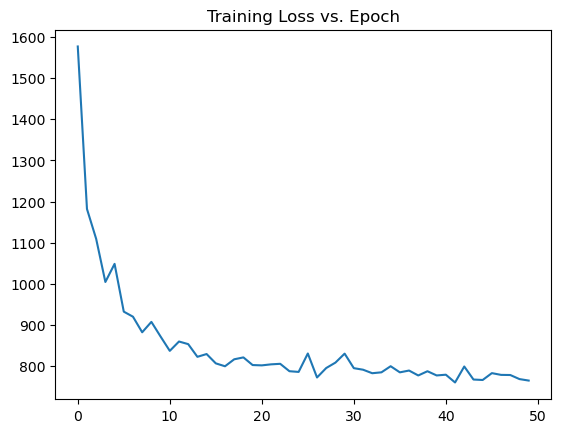

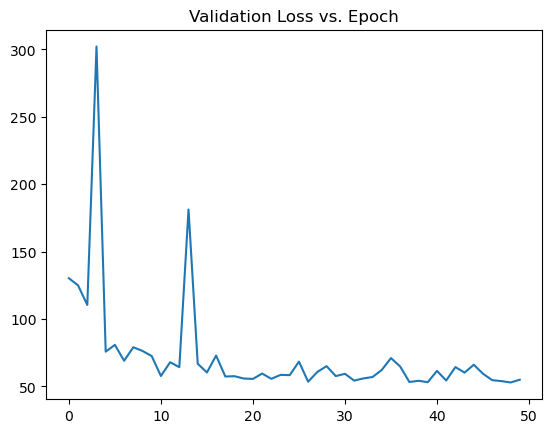

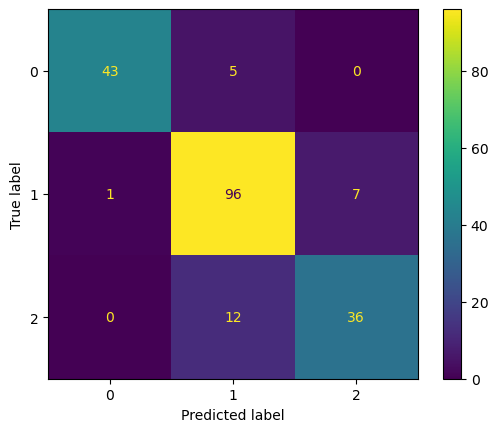

In [1037]:
classify_insurability()

## MNIST

Accuracy: 86.0%


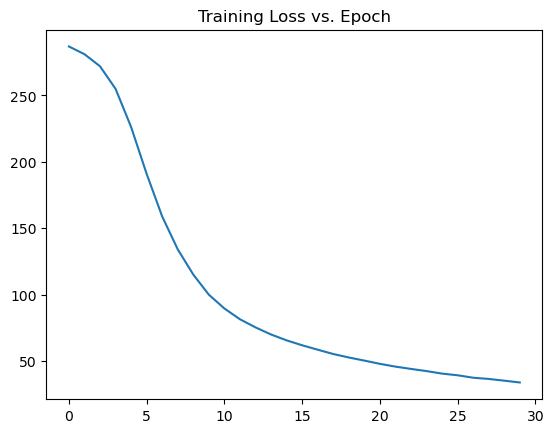

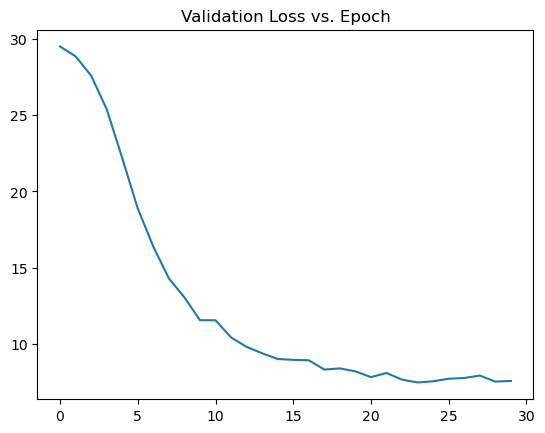

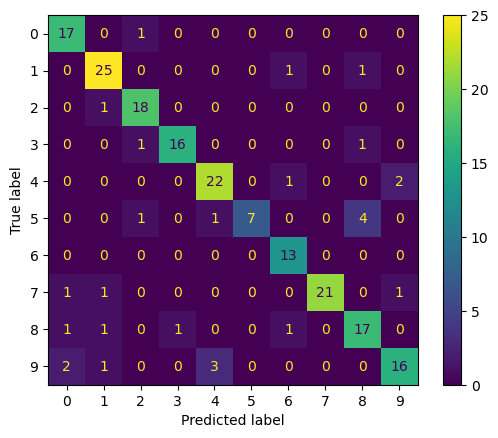

In [1043]:
classify_mnist()

## MNSIT (with regularization)

Accuracy: 85.0%


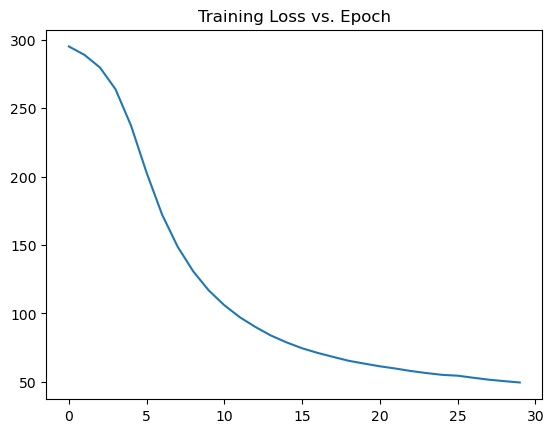

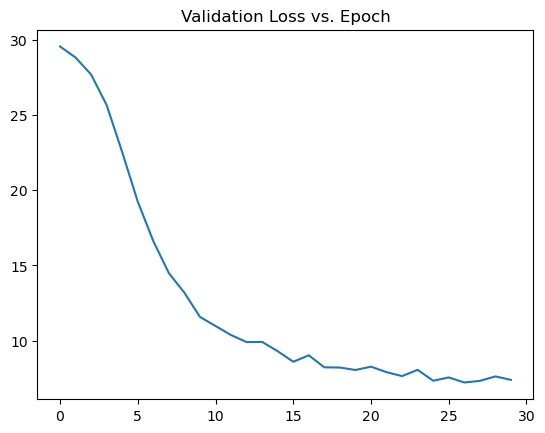

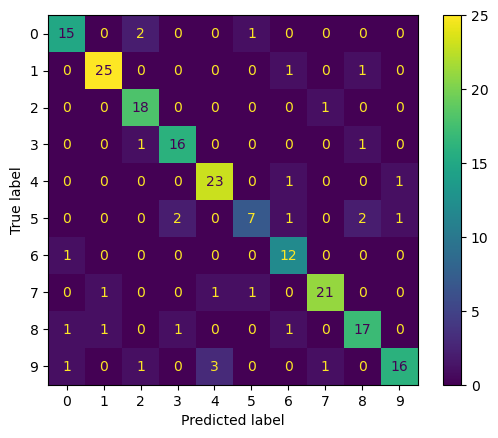

In [1060]:
classify_mnist_reg()